# fig4paper-ex

## Configuration 

In [1]:
%precision 4
%load_ext autoreload
%autoreload 2
%load_ext version_information
from IPython.display import display
%matplotlib inline

In [2]:
%version_information numpy, scipy, matplotlib

Software versions
Python 3.6.4 64bit [MSC v.1900 64 bit (AMD64)]
IPython 6.2.1
OS Windows 10 10.0.17134 SP0
numpy 1.14.0
scipy 1.0.0
matplotlib 2.1.2
Wed Aug 01 14:46:02 2018 ???? (?W???)

In [3]:
from imp import reload
from os import path
import numpy as np
import scipy as sp
from scipy import linalg, arccos
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import axes3d

In [4]:
import lib.Lode as ode
import lib.Ldata as dm
import lib.Ldraw as vis

C:\Users\ryoikota\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
def cart2spher(xyz):
    r = linalg.norm(xyz)
    rho = linalg.norm(xyz[:2])
    theta = arccos(xyz[2]/r)
    phi = arccos(xyz[0]/rho)
    return np.array((r,theta,phi))

In [6]:
%run conf_fig

In [7]:
mpl.RcParams.update(style)


## Data

In [8]:
data = dm.loadData(path.join('data','lm_orbit.hdf5'))

tarray=data['tarray']
dt = tarray[1] - tarray[0]
nfold = len(data['xyz'])

In [9]:
evecA = data['eigVecDF']
evalA = data['eigValDF']
evalB = sp.real(data['eigValSymDF'])
evecB = data['eigVecSymDF']

param = data['param']

orbits = data['xyz']
ref = np.copy(orbits[0,:,:])
xyz = np.copy(ref)

ref = ref[np.newaxis]

perturbed = np.copy(orbits[1:,:,:])
diff = perturbed - ref
diffsq = diff**2
_h = np.sum(diffsq, axis=-1)
normDiff = np.sqrt(_h)

DevecB = evecB[1:] - evecB[:-1]

In [10]:
SDF = [] # (DF + DF^T)/2
ADF = [] # (DF - DF^2)/2
gab1 = [] # gamma, alpha, beta
gab2 = []
A1 = []
A2 = []

for p,t,E,dE in zip(xyz[:-1],
                tarray[:-1],
                evecB[:-1],
              DevecB):
    _SDF = ode.SDF(p,t,*param)
    _ADF = ode.ADF(p,t,*param)
    _A2 = E @ _ADF @ E.T
    _A1 = -E @ (dE.T/dt) + _A2
    SDF.append(_SDF)
    ADF.append(_ADF)
    A1.append(_A1)
    A2.append(_A2)
    
    
SDF = np.array(SDF)
ADF = np.array(ADF)
A1 = np.array(A1)
A2 = np.array(A2)

In [11]:
omega12 = []
gab12 = []
for A in (A1,A2):
    _omega = np.array((A[:,1,2],-A[:,0,2],A[:,0,1]))
    gamma = linalg.norm(_omega,axis=0)
    omega = _omega/gamma
    beta = sp.sum(evalB[:-1].T * (omega**2), axis=0)
    alpha = (sp.sum(evalB[:-1].T, axis=0) - beta)/2.0
    omega12.append(omega)
    gab12.append((gamma,alpha,beta))

In [12]:
upto1h = slice(0,301)
upto3 = slice(0,601)
upto6 = slice(0,1201)

## Figures

In [13]:
Figs = []

### Growth Rate 

In [14]:
maxRealEig = np.max(sp.real(evalA),axis=-1)

grate_diff =  (sp.log(normDiff)[:,1:] 
               - sp.log(normDiff)[:,:-1])/dt

In [15]:
def plotDiff(ax):
    for grd in grate_diff:
        
        ax.plot(tarray[upto3], 
                grd[upto3],
                ls='--',
                lw=0.5)
    

In [16]:
def getAXGR(gs):
    ax = figGR.add_subplot(gs)
    ax.set_xlim([0.0,3.0])
    ax.set_ylim([-6.0,10.0])
    ax.grid(True)
    return ax

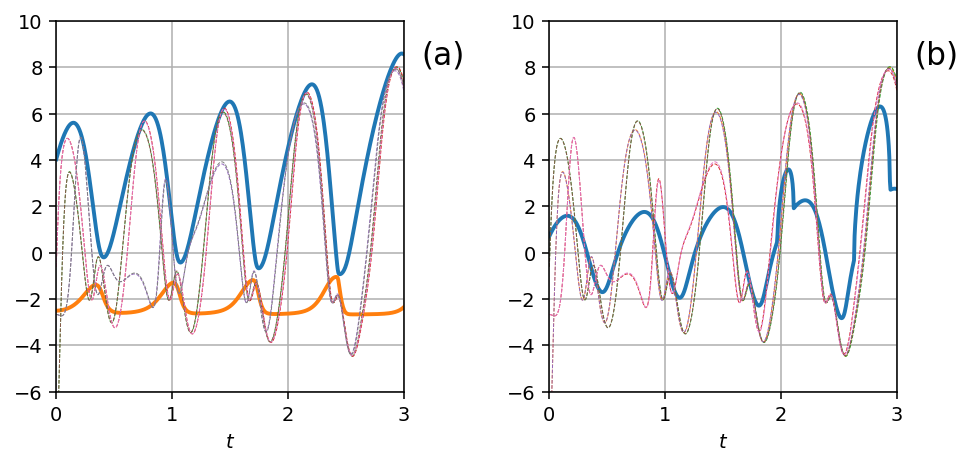

In [17]:
figGR = plt.figure(figsize=(width_1col, 0.7*width_1col),
                        dpi = 140
                        )
gsGR = gridspec.GridSpec(1,2)
gamma2,alpha2,beta2 = gab12[1]

ax1 = getAXGR(gsGR[0,0])
ax1.plot(tarray[upto3],evalB[upto3,0],lw=2.0)
ax1.plot(tarray[upto3], evalB[upto3,1],lw=2.0)
plotDiff(ax1)
ax1.set_aspect(0.2)
ax1.set_xlabel(r'$t$')
ax1.set_xticks([x for x in range(4)])
ax1.annotate('(a)',
             (1.05,0.95),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16
            );

ax2 = getAXGR(gsGR[0,1])
ax2.plot(tarray[upto3], maxRealEig[upto3],lw=2.0)

plotDiff(ax2)
ax2.set_aspect(0.2)
ax2.set_xlabel(r'$t$')
ax2.set_xticks([x for x in range(4)])
ax2.annotate('(b)',
             (1.05,0.95),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16
            );

gsGR.tight_layout(figGR,
                 w_pad=5.0,
                 rect=(0.,0.,0.95,1.0)
                 )

In [18]:
Figs.append((figGR,'figGR.pdf'))

### Eigenvalues

### psi_i, omega

In [19]:
sphc = []
for _evecB in evecB:
    _sphc = []
    for v in _evecB:
        _rtp = cart2spher(v)
        _sphc.append(_rtp)
    sphc.append(_sphc)
sphc = np.array(sphc)

In [20]:
omega12_sphc = []
for omega in omega12:

    omega_sphc = []
    for _omega in omega.T:
        _rtp = cart2spher(_omega)
        omega_sphc.append(_rtp)
    omega12_sphc.append(np.array(omega_sphc))
    

In [21]:
sphc_02 = omega12_sphc[1]

In [22]:
th_ticks = np.arange(0.0,np.pi*0.76,np.pi/4)

th_ticklabels = [r'$0$',r'$\pi/4$', 
                 r'$\pi/2$', r'$3\pi/4$']

phi_ticks = np.arange(np.pi*0.5,np.pi*1.1,np.pi/4)

phi_ticklabels = [r'$\pi/2$', r'$3\pi/4$',
                 r'$\pi$']

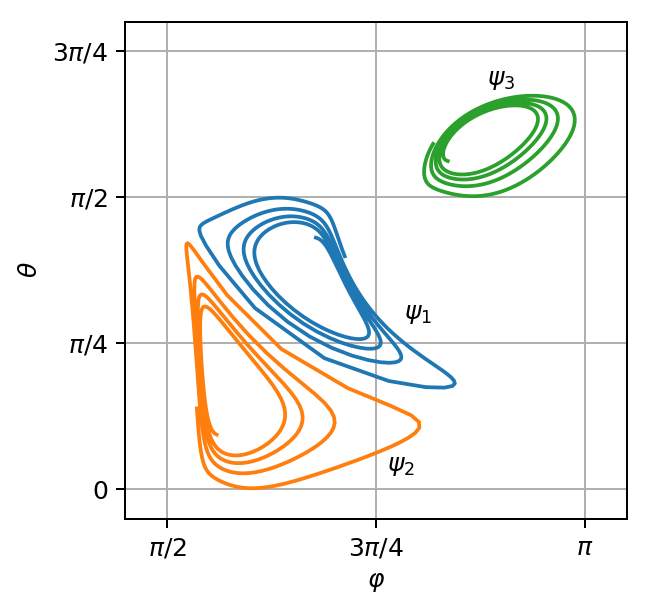

In [23]:
figPsi = plt.figure(figsize=(0.8*width_1col, 0.5*width_1col),
                   dpi=180)
gsPsi = gridspec.GridSpec(1,1)
ax = figPsi.add_subplot(gsPsi[0])
ax.set_ylim([-0.05*sp.pi, 3.0*sp.pi/4.0 + 0.05*sp.pi])
ax.set_xlim([sp.pi/2.0 - 0.05*sp.pi,sp.pi + 0.05*sp.pi])
ax.set_yticks(th_ticks)
ax.set_yticklabels(th_ticklabels)
ax.set_xticks(phi_ticks)
ax.set_xticklabels(phi_ticklabels)
ax.grid(True)
ax.plot(sphc[upto3,0,2],sphc[upto3,0,1])
ax.plot(sphc[upto3,1,2],sphc[upto3,1,1])
ax.plot(sphc[upto3,2,2],sphc[upto3,2,1])
ax.set_aspect(0.7)
ax.set_ylabel(r'$\theta$')
ax.set_xlabel(r'$\varphi$')
for label, xy in zip([r'$\psi_{0:d}$'.format(i) 
                      for i in range(1,4)],
                    [(0.8*np.pi, 0.3*np.pi),
                    (0.78*np.pi,0.04*np.pi),
                    (0.9*np.pi,0.7*np.pi)]):
    ax.annotate(label,
              xy=xy,
              xycoords='data',
              va='center',
              ha='center')
gsPsi.tight_layout(figPsi,
                  w_pad=5.0,
                  rect=(0.,0.,0.95,1.0)
                  )

In [24]:
Figs.append((figPsi,'figPsi.pdf'))

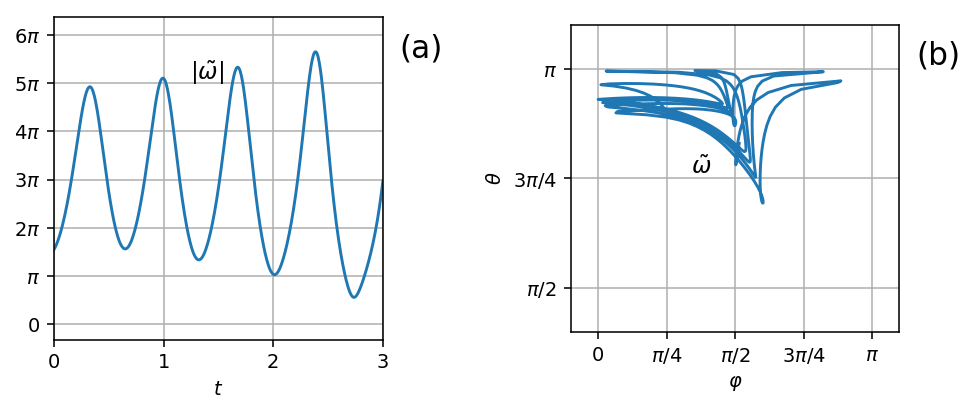

In [25]:
figOMG = plt.figure(figsize=(width_1col, 0.8*width_1col),
                        dpi = 140
                        )
gsOMG = gridspec.GridSpec(1,2)
gamma2,alpha2,beta2 = gab12[1]

ax1 = figOMG.add_subplot(gsOMG[0])
ax1.set_xlim([0.,3.])
ax1.set_ylim([-1.,20.])
ax1.plot(tarray[upto3], gamma2[upto3])
ax1.grid(True)
ax1.set_xlabel(r'$t$')
ax1.set_aspect(0.14)
ax1.set_yticks([x*np.pi for x in range(7)])
ax1.set_yticklabels([r'$0$', r'$\pi$']\
                    + [r'${0:d}\pi$'.format(i) for i in range(2,7)]
                    )
ax1.annotate(r'$|\tilde{\omega}|$',
            xy=(1.4,15.5),
            xycoords='data',
            va="bottom",
            ha="center",
            fontsize=12)
ax1.annotate('(a)',
             (1.05,0.95),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16
            );

ax2 = figOMG.add_subplot(gsOMG[1])
ax2.set_ylim([np.pi/2.0 - 0.1*np.pi, np.pi + 0.1*np.pi])
ax2.set_xlim([-0.1*np.pi, np.pi + 0.1*np.pi])
ax2.set_yticks(np.arange(np.pi/2.0, np.pi + 0.1, np.pi/4.0))
ax2.set_yticklabels([r'$\pi/2$',r'$3\pi/4$', r'$\pi$'])
ax2.set_xticks(np.arange(0.0, np.pi+0.1,np.pi/4.0))
ax2.set_xticklabels([r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
ax2.grid(True)
ax2.plot(sphc_02[upto3,2],sphc_02[upto3,1])
ax2.set_aspect(1.6)
ax2.set_ylabel(r'$\theta$')
ax2.set_xlabel(r'$\varphi$')
ax2.annotate(r'$\tilde{\omega}$',
            xy=(1.5/4.0*np.pi,3.1/4.0*np.pi),
            xycoords='data',
            va="center",
            ha="center",
            fontsize=12)
ax2.annotate('(b)',
                 (1.05,0.95),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16
            );

gsOMG.tight_layout(figOMG,
                  w_pad=5.0,
                  rect=(0.,0.,0.95,1.0))

In [26]:
Figs.append((figOMG,'figOMG.pdf'))

In [27]:
for f,fn in Figs:
    f.savefig(path.join('..','figs',fn))